In [1]:
# Import necessary libraries, set random seeds for reproducibility, and define computing device
!pip install matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Define evaluate function to compute model accuracy on a given dataset
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [3]:
# Prepare data transformations, load CIFAR10 dataset, and set up training and testing data loaders

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(), 
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)), 
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5303, 0.4737, 0.4658], std=[0.2822, 0.2553, 0.2613])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(testset, batch_size=100, shuffle=False)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
# Define BasicBlock and ResNet model classes, including a custom ResNet model initialization function
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 66

        self.conv1 = nn.Conv2d(3, 66, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(66)


        self.layer1 = self._make_layer(block, 66, num_blocks[0], stride=1)

        self.layer2 = self._make_layer(block, 132, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 264, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(264 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetCustom():
    return ResNet(BasicBlock, [3, 4, 3], num_classes=10)

model = ResNetCustom().to(device)

In [5]:
# Define custom SmoothCrossEntropyLoss class for label-smoothing loss calculation
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.05):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [6]:
# Setting up learning rate scheduler for adaptive learning rate adjustment during training
from torch.optim.lr_scheduler import LambdaLR
import math
model = ResNetCustom().to(device)
criterion = SmoothCrossEntropyLoss(smoothing=0.05).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)

def warmup_with_cosine_lr(epoch):
    if epoch < 10:
        return epoch / 10
    else:
        return 0.5 * (1. + math.cos(math.pi * (epoch - 5) / (epochs - 5)))


scheduler = LambdaLR(optimizer, lr_lambda=warmup_with_cosine_lr)

In [17]:
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of Trainable Parameters: {model_parameters}")

from torchinfo import summary

# Move model to device
model = ResNetCustom().to(device)

# Generate the summary
summary(model, input_size=(1, 3, 32, 32))

Number of Trainable Parameters: 4916284


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 66, 32, 32]           1,782
├─BatchNorm2d: 1-2                       [1, 66, 32, 32]           132
├─Sequential: 1-3                        [1, 66, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 66, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 66, 32, 32]           39,204
│    │    └─BatchNorm2d: 3-2             [1, 66, 32, 32]           132
│    │    └─Conv2d: 3-3                  [1, 66, 32, 32]           39,204
│    │    └─BatchNorm2d: 3-4             [1, 66, 32, 32]           132
│    │    └─Sequential: 3-5              [1, 66, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 66, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 66, 32, 32]           39,204
│    │    └─BatchNorm2d: 3-7             [1, 66, 32, 32]           

In [8]:
# Define the training loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

def train(epoch):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%')

def validate(epoch):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(100. * correct / total)
    print(f'Epoch: {epoch}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

In [9]:
# Training and evaluation loop
epochs = 60
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
lr_changes = []

for epoch in range(epochs):
    train(epoch)
    validate(epoch)
    scheduler.step()
    lr_changes.append(optimizer.param_groups[0]['lr'])

model_save_path = './model_weights.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Epoch: 0, Train Loss: 2.4128, Train Acc: 10.11%
Epoch: 0, Val Loss: 2.3728, Val Acc: 10.26%
Epoch: 1, Train Loss: 1.9086, Train Acc: 32.06%
Epoch: 1, Val Loss: 1.6615, Val Acc: 43.49%
Epoch: 2, Train Loss: 1.5597, Train Acc: 47.73%
Epoch: 2, Val Loss: 1.6428, Val Acc: 51.29%
Epoch: 3, Train Loss: 1.3407, Train Acc: 57.81%
Epoch: 3, Val Loss: 1.2872, Val Acc: 64.76%
Epoch: 4, Train Loss: 1.2020, Train Acc: 63.91%
Epoch: 4, Val Loss: 1.1702, Val Acc: 68.78%
Epoch: 5, Train Loss: 1.1096, Train Acc: 68.28%
Epoch: 5, Val Loss: 1.0297, Val Acc: 72.51%
Epoch: 6, Train Loss: 1.0437, Train Acc: 70.77%
Epoch: 6, Val Loss: 0.9703, Val Acc: 75.46%
Epoch: 7, Train Loss: 0.9974, Train Acc: 72.35%
Epoch: 7, Val Loss: 0.9058, Val Acc: 77.85%
Epoch: 8, Train Loss: 0.9515, Train Acc: 74.41%
Epoch: 8, Val Loss: 0.7942, Val Acc: 82.04%
Epoch: 9, Train Loss: 0.9159, Train Acc: 75.91%
Epoch: 9, Val Loss: 0.8751, Val Acc: 79.41%
Epoch: 10, Train Loss: 0.8919, Train Acc: 77.01%
Epoch: 10, Val Loss: 0.8856, Va

In [10]:
test_accuracy = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")

Final Test Accuracy: 95.56%


In [11]:
import pickle
import pandas as pd

# Load model from pkl file for testing
pkl_model_path = 'cifar_test_nolabel.pkl'
with open(pkl_model_path, 'rb') as f:
    custom_test_data = pickle.load(f)

# Extract the data correctly
if isinstance(custom_test_data, dict):
    custom_test_data = custom_test_data[b'data']

# Convert to tensor and preprocess
custom_test_data = torch.tensor(custom_test_data, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0

# Move data to the device before normalization
custom_test_data = custom_test_data.to(device)

# Normalize with custom mean and std
mean = torch.tensor([0.4765, 0.4808, 0.4958]).view(3, 1, 1).to(device)
std = torch.tensor([0.2303, 0.2267, 0.2268]).view(3, 1, 1).to(device)
custom_test_data = (custom_test_data - mean) / std

# Run inference
model.eval()
with torch.no_grad():
    outputs = model(custom_test_data)
    _, predictions = torch.max(outputs, 1)

# Save predictions to CSV with correct ID column name
submission_df = pd.DataFrame({"ID": range(len(predictions)), "Category": predictions.cpu().numpy()})
submission_df.to_csv("submissions.csv", index=False)

print("Predictions saved to submissions.csv")

Predictions saved to submissions_final2.csv


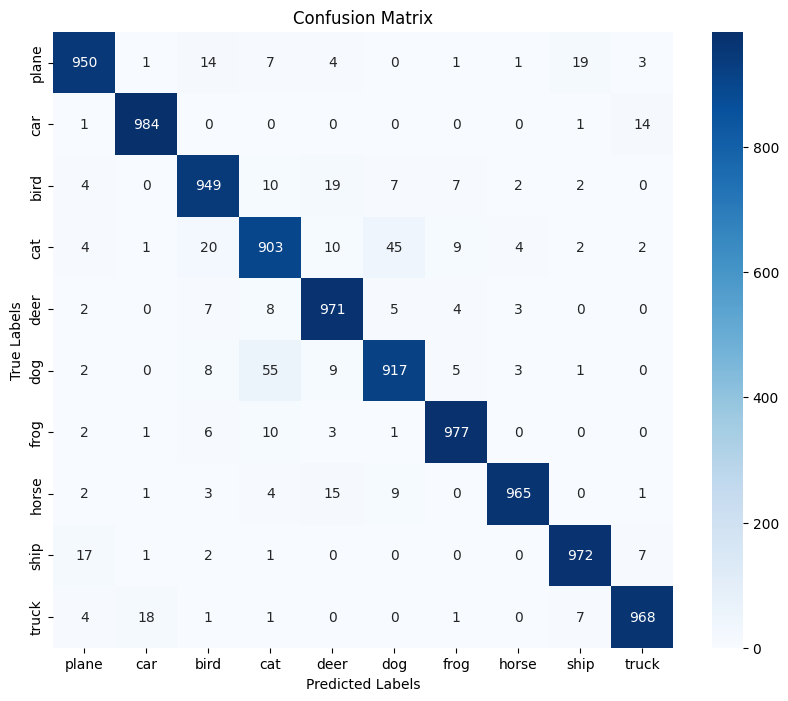

In [12]:
# Evaluate model on test set to generate predictions, calculate confusion matrix, and visualize it
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.view(-1).tolist())
        y_true.extend(labels.view(-1).tolist())

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
     

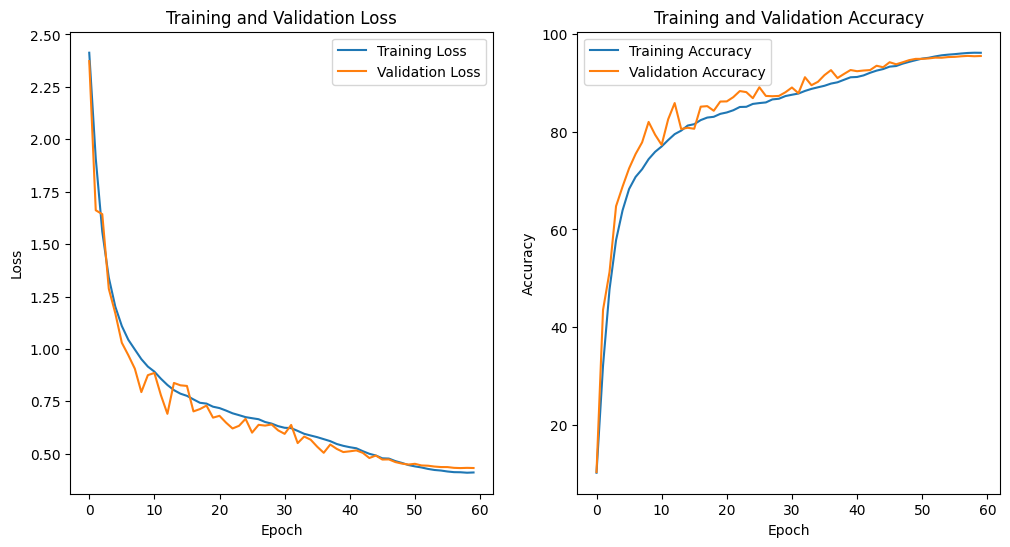

In [13]:
# Visualize training, validation loss and accuracy on subplots to compare performance over epochs

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
# System Specifications
import sys
import torch

!cat /proc/cpuinfo | grep 'model name' | uniq | awk -F: '{print "CPU:", $2}'
!nvidia-smi --query-gpu=gpu_name --format=csv,noheader | awk '{1};1' | awk '{print "GPU:", $0}'
!cat /proc/meminfo | grep 'MemTotal' | awk '{print "System Memory:", $2/1024/1024, "GB"}'
print("Python Version:", sys.version)
print("CUDA version:", torch.version.cuda)
print("Torch Version:", torch.__version__)



CPU:  Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: NVIDIA A100-SXM4-40GB
System Memory: 82.9648 GB
Python Version: 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
CUDA version: 12.4
Torch Version: 2.6.0+cu124
